In [95]:
import pandas as pd
import numpy as np
import cellanneal
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

In [86]:
signature_path = "example_data/signature_data_human_liver.csv"

# import single-cell based signature data
signature_df = pd.read_csv(signature_path, index_col=0)

In [87]:
def generate_random_weights(n: int) -> np.ndarray:
    # Generate n random floats that sum to 1
    return np.random.dirichlet(np.ones(n), size=1)

In [88]:
def generate_samples(n: int, signature_df: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
    # Generate n random samples from the signature data
    # Each sample is a weighted sum of the cell types
    # The weights are generated by generate_random_weights()
    # The samples are stored in a pandas DataFrame
    samples = pd.DataFrame()
    celltype_weights = pd.DataFrame(columns=signature_df.columns)
    
    for i in range(n):
        celltype_weights.loc[i] = generate_random_weights(len(signature_df.columns)).T.flatten()
        samples[i] = signature_df.values.dot(celltype_weights.loc[i])
        
    celltype_weights.rename(index={i: f"sample_{i}" for i in range(n)}, inplace=True)
    samples.rename(columns={i: f"sample_{i}" for i in range(n)}, inplace=True)
    samples.rename(index={i: gene for i, gene in enumerate(signature_df.index)}, inplace=True)
    return samples, celltype_weights

samples, celltype_weights = generate_samples(5, signature_df)

In [89]:
all_mix_df = cellanneal.run_cellanneal(
    signature_df, samples, disp_min=0.5, bulk_min=1e-5, bulk_max=0.01, maxiter=1000
)


+++ Constructing gene sets ... +++
3715 highly variable genes identified in cell type
        reference.
	3145 of these are within thresholds for sample sample_0
	3025 of these are within thresholds for sample sample_1
	3151 of these are within thresholds for sample sample_2
	3081 of these are within thresholds for sample sample_3
	3077 of these are within thresholds for sample sample_4

+++ Running cellanneal ... +++
Deconvolving sample 1 of 5 (sample_0) ...
Deconvolving sample 2 of 5 (sample_1) ...
Deconvolving sample 3 of 5 (sample_2) ...
Deconvolving sample 4 of 5 (sample_3) ...
Deconvolving sample 5 of 5 (sample_4) ...


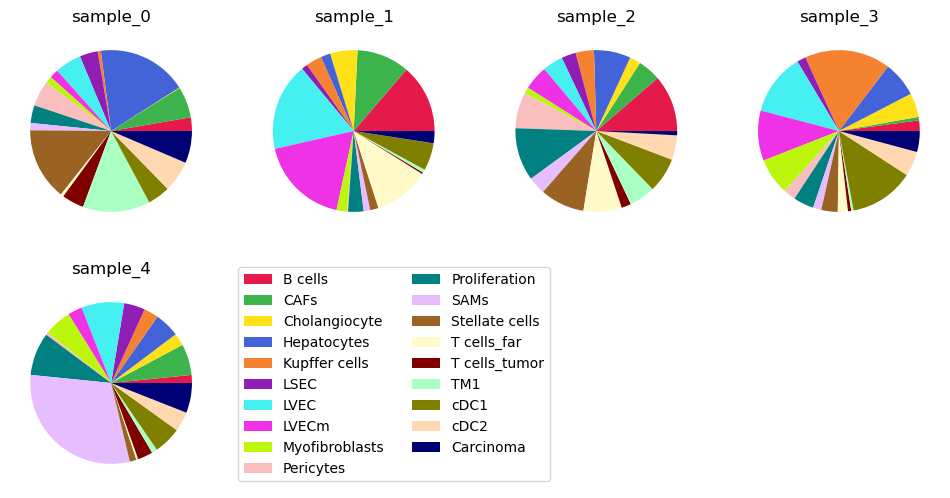

In [105]:
# Plot of the "simulated" cell type weights for each sample
cellanneal.plot_pies(celltype_weights)

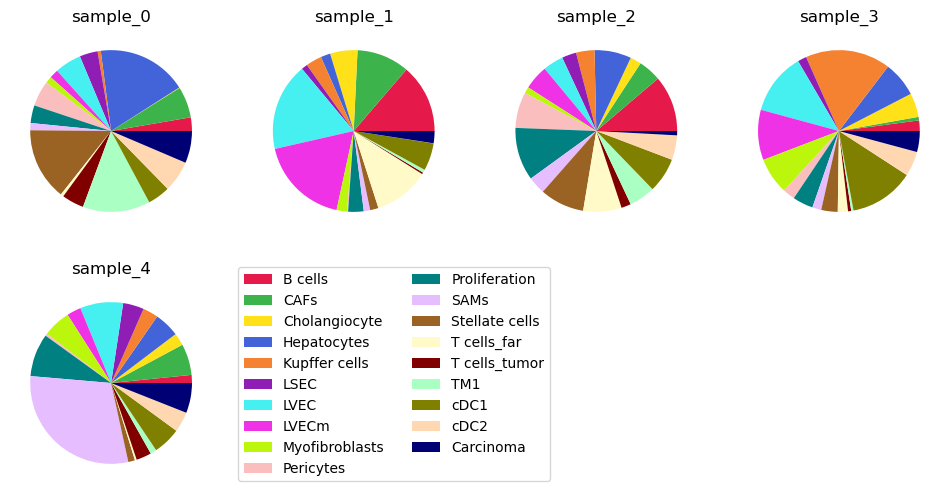

In [107]:
# Plot of the cellanneal results
cellanneal.plot_pies(all_mix_df)

In [ ]:
def plot_celltype_weights(celltype_weights: pd.DataFrame) -> None:
    n_rows = len(celltype_weights) // 2 + len(celltype_weights) % 2
    specs = [[{"type": "pie"}]*2 for _ in range(n_rows)]
    fig = make_subplots(
        rows=n_rows, 
        cols=2, 
        # Set titles to white
        subplot_titles=([f"<span style='color:#FFFFFF;'>{sample}</span>" for sample in celltype_weights.index]),
        specs=specs,
        
    )
    
    for index, row in celltype_weights.iterrows():
        fig.add_trace(
            go.Pie(
                labels=row.index, 
                values=row.values, 
                showlegend=True,  # Add a legend
                textinfo="label+percent",
                textposition="inside",
                marker=dict(colors=px.colors.qualitative.Alphabet),
                hovertemplate=
                    "%{label}</b><br>" +
                    "Weight: %{percent}<br>" +
                    "<extra></extra>",
            ), 
            row=int(index[-1]) // 2 + 1, 
            col=int(index[-1]) % 2 + 1,
        )
    
    # Increase the size of the plots
    fig.update_layout(
        # TODO: These need to be not-hardcoded
        width=600,  # Set the width of the plot
        height=1500,  # Set the height of the plot
        legend=dict(
            x=0.5,  # Set the x position of the legend
            y=-0.1,  # Set the y position of the legend
            orientation="h",  # Set the orientation of the legend to horizontal
            font=dict(
                size=16,
                color="white"
            )
        )
    )
    fig.update_layout(paper_bgcolor = "black")
    fig.show()

plot_celltype_weights(celltype_weights)